In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load all the datasets


In [79]:
# Load datasets
vendors = pd.read_csv('Train/vendors.csv')
orders = pd.read_csv('Train/orders.csv')
train_customers = pd.read_csv('Train/train_customers.csv')
train_locations = pd.read_csv('Train/train_locations.csv')
test_customers = pd.read_csv('Test/test_customers.csv')
test_locations = pd.read_csv('Test/test_locations.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')

C:\Users\adars\AppData\Local\Temp\ipykernel_408\1195599220.py:3: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  orders = pd.read_csv('Train/orders.csv')


# Basic dataset overview and missing value analysis


In [80]:
datasets = {
    'Vendors': vendors,
    'Orders': orders,
    'Train Customers': train_customers,
    'Train Locations': train_locations,
    'Test Customers': test_customers,
    'Test Locations': test_locations
}

In [81]:
# Basic dataset overview and missing value analysis


missing_summary = []

for name, df in datasets.items():
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isnull().sum().sum()
    missing_percentage = (missing_cells / total_cells) * 100
    
    missing_summary.append({
        'Dataset': name,
        'Total Cells': total_cells,
        'Missing Cells': missing_cells,
        'Missing %': missing_percentage,
        'Complete Rows': df.dropna().shape[0],
        'Complete %': (df.dropna().shape[0] / df.shape[0]) * 100
    })

missing_df = pd.DataFrame(missing_summary)
print(missing_df.round(2).to_string(index=False))

# Display datasets
datasets

        Dataset  Total Cells  Missing Cells  Missing %  Complete Rows  Complete %
        Vendors         5900            903      15.31             19       19.00
         Orders      3517878         956333      27.18              0        0.00
Train Customers       277392          57357      20.68           1934        5.58
Train Locations       297515          27221       9.15          32292       54.27
 Test Customers        78144          16207      20.74            517        5.29
 Test Locations        83600           7656       9.16           9070       54.25


{'Vendors':      id  authentication_id   latitude  longitude vendor_category_en  \
 0     4             118597  -0.588596   0.754434        Restaurants   
 1    13             118608  -0.471654   0.744470        Restaurants   
 2    20             118616  -0.407527   0.643681        Restaurants   
 3    23             118619  -0.585385   0.753811        Restaurants   
 4    28             118624   0.480602   0.552850        Restaurants   
 ..  ...                ...        ...        ...                ...   
 95  849             130455  -1.588060  -0.066441        Restaurants   
 96  855             130463   2.145206   0.745025        Restaurants   
 97  856             130464   0.251469   0.483633        Restaurants   
 98  858             130468   0.019817   0.587087        Restaurants   
 99  907             132953  13.335131  -1.449556        Restaurants   
 
     vendor_category_id  delivery_charge  serving_distance  is_open  \
 0                    2              0.0            

# Missing Value Analysis and Cleaning


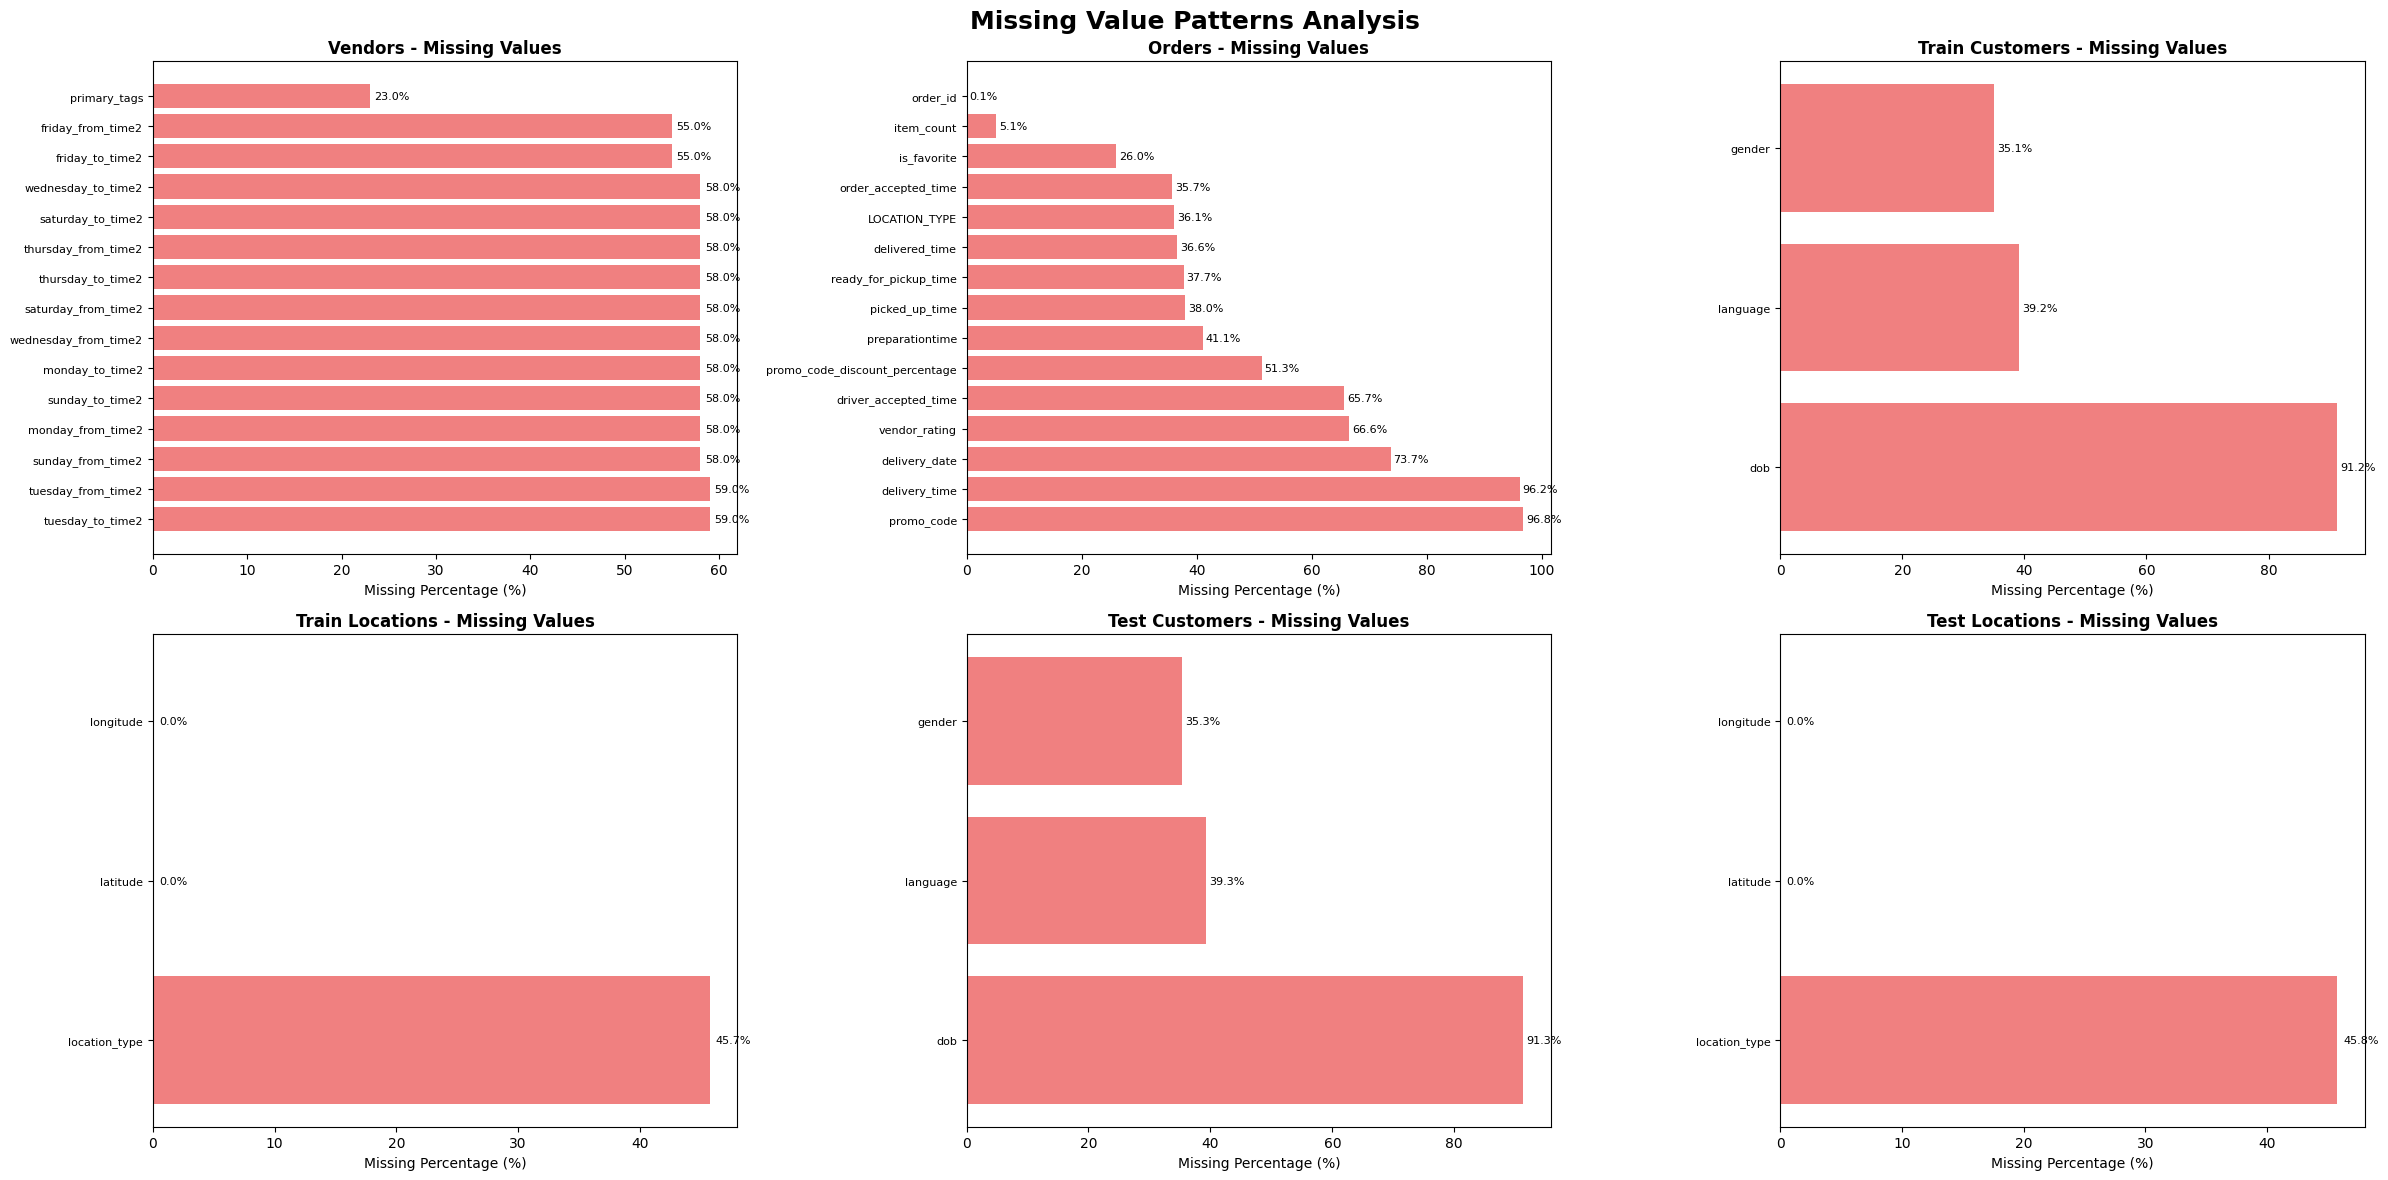

In [82]:
def visualize_missing_patterns():
    # Missing value visualization
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    fig.suptitle('Missing Value Patterns Analysis', fontsize=18, fontweight='bold')

    datasets_to_analyze = {
        'Vendors': vendors,
        'Orders': orders,
        'Train Customers': train_customers,
        'Train Locations': train_locations,
        'Test Customers': test_customers,
        'Test Locations': test_locations
    }

    positions = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]

    for i, (name, df) in enumerate(datasets_to_analyze.items()):
        row, col = positions[i]

        # Calculate missing percentages per column
        missing_pct = (df.isnull().sum() / len(df)) * 100
        missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

        if len(missing_pct) > 0:
            # Limit to top 15 columns for readability
            missing_pct_top = missing_pct.head(15)
            bars = axes[row, col].barh(range(len(missing_pct_top)), missing_pct_top.values, color='lightcoral')
            axes[row, col].set_yticks(range(len(missing_pct_top)))
            axes[row, col].set_yticklabels(missing_pct_top.index, fontsize=8)
            axes[row, col].set_xlabel('Missing Percentage (%)')
            axes[row, col].set_title(f'{name} - Missing Values', fontsize=12, fontweight='bold')
            
            # Add percentage labels on bars
            for j, bar in enumerate(bars):
                width = bar.get_width()
                if width > 0:
                    axes[row, col].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                                        f'{width:.1f}%', ha='left', va='center', fontsize=8)
        else:
            axes[row, col].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
                                transform=axes[row, col].transAxes, fontsize=14, fontweight='bold')
            axes[row, col].set_title(f'{name} - Complete Dataset', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()
visualize_missing_patterns()

# 3. Smart Missing Value Filling Strategy


In [83]:
def smart_missing_value_filling():
    """Intelligent missing value filling based on data type and business logic"""
    
    print("="*80)
    print("SMART MISSING VALUE FILLING")
    print("="*80)
    
    # Create copies for safe manipulation
    vendors_clean = vendors.copy()
    orders_clean = orders.copy()
    train_customers_clean = train_customers.copy()
    train_locations_clean = train_locations.copy()
    
    # VENDORS DATASET CLEANING
    print("\n1. CLEANING VENDORS DATASET:")
    vendors_missing_before = vendors_clean.isnull().sum().sum()
    
    # Fill numeric missing values
    numeric_cols = vendors_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if vendors_clean[col].isnull().sum() > 0:
            if col in ['vendor_rating']:
                # Use median for ratings
                vendors_clean[col].fillna(vendors_clean[col].median(), inplace=True)
            elif col in ['delivery_charge', 'commission']:
                # Use mode for charges (most common value)
                vendors_clean[col].fillna(vendors_clean[col].mode()[0], inplace=True)
            elif col in ['serving_distance', 'prepration_time']:
                # Use median for distance/time
                vendors_clean[col].fillna(vendors_clean[col].median(), inplace=True)
            else:
                # Default to median for other numeric columns
                vendors_clean[col].fillna(vendors_clean[col].median(), inplace=True)
    
    # Fill categorical missing values
    categorical_cols = vendors_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if vendors_clean[col].isnull().sum() > 0:
            if col in ['OpeningTime', 'OpeningTime2']:
                vendors_clean[col].fillna('Not Available', inplace=True)
            elif col in ['vendor_tag_name', 'primary_tags']:
                vendors_clean[col].fillna('General', inplace=True)
            else:
                vendors_clean[col].fillna('Unknown', inplace=True)
    
    vendors_missing_after = vendors_clean.isnull().sum().sum()
    print(f"   - Missing values reduced: {vendors_missing_before} -> {vendors_missing_after}")
    
    # ORDERS DATASET CLEANING
    print("\n2. CLEANING ORDERS DATASET:")
    orders_missing_before = orders_clean.isnull().sum().sum()
    
    # Handle key missing values strategically
    # Fill promo_code (most orders don't have promos)
    orders_clean['promo_code'].fillna('NO_PROMO', inplace=True)
    orders_clean['promo_code_discount_percentage'].fillna(0, inplace=True)
    orders_clean['vendor_discount_amount'].fillna(0, inplace=True)
    
    # Fill rating fields
    orders_clean['is_favorite'].fillna('No', inplace=True)
    orders_clean['vendor_rating'].fillna(0, inplace=True)
    orders_clean['driver_rating'].fillna(0, inplace=True)
    
    # Fill delivery time fields with median
    time_columns = ['deliverydistance', 'preparationtime', 'delivery_time']
    for col in time_columns:
        if col in orders_clean.columns:
            orders_clean[col] = pd.to_numeric(orders_clean[col], errors='coerce')
            orders_clean[col].fillna(orders_clean[col].median(), inplace=True)
    
    # Fill item count with mode (most common number of items)
    if orders_clean['item_count'].isnull().sum() > 0:
        orders_clean['item_count'].fillna(orders_clean['item_count'].mode()[0], inplace=True)
    
    orders_missing_after = orders_clean.isnull().sum().sum()
    print(f"   - Missing values reduced: {orders_missing_before} -> {orders_missing_after}")
    
    # CUSTOMERS DATASET CLEANING
    print("\n3. CLEANING CUSTOMERS DATASET:")
    customers_missing_before = train_customers_clean.isnull().sum().sum()
    
    # Fill missing dates of birth
    train_customers_clean['dob'].fillna('1990-01-01', inplace=True)  # Default birth year
    
    # Fill other categorical fields
    train_customers_clean['gender'].fillna('Unknown', inplace=True)
    train_customers_clean['language'].fillna('EN', inplace=True)  # Most common language
    
    customers_missing_after = train_customers_clean.isnull().sum().sum()
    print(f"   - Missing values reduced: {customers_missing_before} -> {customers_missing_after}")
    
    # LOCATIONS DATASET CLEANING
    print("\n4. CLEANING LOCATIONS DATASET:")
    locations_missing_before = train_locations_clean.isnull().sum().sum()
    
    # Fill missing location types with most common
    train_locations_clean['location_type'].fillna('Home', inplace=True)  # Assume Home if unknown
    
    # For missing coordinates, could use city center or median
    if train_locations_clean['latitude'].isnull().sum() > 0:
        train_locations_clean['latitude'].fillna(train_locations_clean['latitude'].median(), inplace=True)
        train_locations_clean['longitude'].fillna(train_locations_clean['longitude'].median(), inplace=True)
    
    locations_missing_after = train_locations_clean.isnull().sum().sum()
    print(f"   - Missing values reduced: {locations_missing_before} -> {locations_missing_after}")
    
    return vendors_clean, orders_clean, train_customers_clean, train_locations_clean

# Apply missing value filling
vendors_clean, orders_clean, train_customers_clean, train_locations_clean = smart_missing_value_filling()

SMART MISSING VALUE FILLING

1. CLEANING VENDORS DATASET:
   - Missing values reduced: 903 -> 0

2. CLEANING ORDERS DATASET:
   - Missing values reduced: 956333 -> 573272

3. CLEANING CUSTOMERS DATASET:
   - Missing values reduced: 57357 -> 0

4. CLEANING LOCATIONS DATASET:
   - Missing values reduced: 27221 -> 0


C:\Users\adars\AppData\Local\Temp\ipykernel_408\97132498.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  vendors_clean[col].fillna(vendors_clean[col].mode()[0], inplace=True)
C:\Users\adars\AppData\Local\Temp\ipykernel_408\97132498.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

# 4. Data Quality Validation


In [84]:
def validate_data_quality():
    """Validate the quality of cleaned data"""
    print("\n" + "="*60)
    print("DATA QUALITY VALIDATION")
    print("="*60)
    
    # Check for remaining missing values
    datasets_clean = {
        'Vendors': vendors_clean,
        'Orders': orders_clean,
        'Train Customers': train_customers_clean,
        'Train Locations': train_locations_clean
    }
    
    validation_results = []
    
    for name, df in datasets_clean.items():
        missing_count = df.isnull().sum().sum()
        duplicate_count = df.duplicated().sum()
        
        validation_results.append({
            'Dataset': name,
            'Missing Values': missing_count,
            'Duplicates': duplicate_count,
            'Data Quality Score': 100 - (missing_count + duplicate_count) / (df.shape[0] * df.shape[1]) * 100
        })
    
    validation_df = pd.DataFrame(validation_results)
    print(validation_df.round(2).to_string(index=False))
    
    # Specific data quality checks
    print(f"\nDATA QUALITY CHECKS:")
    print(f"   - Vendor ratings range: {vendors_clean['vendor_rating'].min():.1f} - {vendors_clean['vendor_rating'].max():.1f}")
    print(f"   - Valid coordinates: {(vendors_clean['latitude'].between(-90, 90) & vendors_clean['longitude'].between(-180, 180)).sum()}/{len(vendors_clean)}")
    print(f"   - Positive order values: {(orders_clean['grand_total'] > 0).sum()}/{len(orders_clean)}")
    print(f"   - Valid vendor IDs in orders: {orders_clean['vendor_id'].isin(vendors_clean['id']).sum()}/{len(orders_clean)}")
    
    return validation_df

# Run validation
validation_results = validate_data_quality()


DATA QUALITY VALIDATION
        Dataset  Missing Values  Duplicates  Data Quality Score
        Vendors               0           0              100.00
         Orders          573272          20               83.70
Train Customers               0          71               99.97
Train Locations               0           0              100.00

DATA QUALITY CHECKS:
   - Vendor ratings range: 3.2 - 4.8
   - Valid coordinates: 99/100
   - Positive order values: 134620/135303
   - Valid vendor IDs in orders: 135303/135303
        Dataset  Missing Values  Duplicates  Data Quality Score
        Vendors               0           0              100.00
         Orders          573272          20               83.70
Train Customers               0          71               99.97
Train Locations               0           0              100.00

DATA QUALITY CHECKS:
   - Vendor ratings range: 3.2 - 4.8
   - Valid coordinates: 99/100
   - Positive order values: 134620/135303
   - Valid vendor IDs in

# Feature Engineering and Training Data Creation


In [85]:
def create_enhanced_features():
    """Create comprehensive features using clean data"""
    print("\n" + "="*60)
    print("ENHANCED FEATURE ENGINEERING")
    print("="*60)
    
    # Start with positive examples (actual orders)
    positive_examples = orders_clean[['customer_id', 'LOCATION_NUMBER', 'vendor_id']].copy()
    positive_examples['target'] = 1
    positive_examples.rename(columns={'LOCATION_NUMBER': 'location_number'}, inplace=True)
    
    # Create strategic negative examples
    print("Creating negative examples...")
    negative_examples = []
    
    # Sample customers for negative examples
    sample_customers = positive_examples['customer_id'].unique()[:1000]  # Manageable size
    
    for customer_id in sample_customers:
        customer_locations = train_locations_clean[train_locations_clean['customer_id'] == customer_id]['location_number'].unique()
        
        for location_num in customer_locations:
            # Get vendors this customer actually used
            used_vendors = positive_examples[
                (positive_examples['customer_id'] == customer_id) & 
                (positive_examples['location_number'] == location_num)
            ]['vendor_id'].unique()
            
            # Sample vendors they didn't use (create negative examples)
            available_vendors = vendors_clean['id'].unique()
            unused_vendors = [v for v in available_vendors if v not in used_vendors]
            
            # Sample 2-3 negative examples per positive
            if len(unused_vendors) > 0:
                sample_size = min(len(unused_vendors), max(2, len(used_vendors) * 2))
                sampled_vendors = np.random.choice(unused_vendors, size=sample_size, replace=False)
                
                for vendor_id in sampled_vendors:
                    negative_examples.append({
                        'customer_id': customer_id,
                        'location_number': location_num,
                        'vendor_id': vendor_id,
                        'target': 0
                    })
    
    negative_df = pd.DataFrame(negative_examples)
    
    # Combine positive and negative examples
    training_data = pd.concat([positive_examples, negative_df], ignore_index=True)
    
    print(f"Training data created:")
    print(f"   - Positive examples: {len(positive_examples):,}")
    print(f"   - Negative examples: {len(negative_df):,}")
    print(f"   - Total: {len(training_data):,}")
    print(f"   - Target balance: {training_data['target'].value_counts().to_dict()}")
    
    return training_data

# Create training data
training_data = create_enhanced_features()


ENHANCED FEATURE ENGINEERING
Creating negative examples...
Training data created:
   - Positive examples: 135,303
   - Negative examples: 16,238
   - Total: 151,541
   - Target balance: {1: 135303, 0: 16238}
Training data created:
   - Positive examples: 135,303
   - Negative examples: 16,238
   - Total: 151,541
   - Target balance: {1: 135303, 0: 16238}


# Comprehensive Feature Addition


In [91]:
def add_comprehensive_features(training_data):
    """Add all possible features for maximum model accuracy"""
    print("\n" + "="*60)
    print("COMPREHENSIVE FEATURE ADDITION")
    print("="*60)
    
    # Merge with vendor information
    training_data = training_data.merge(
        vendors_clean[['id', 'latitude', 'longitude', 'vendor_rating', 'vendor_category_en',
                      'delivery_charge', 'serving_distance', 'prepration_time', 'commission',
                      'discount_percentage', 'verified', 'rank']],
        left_on='vendor_id', right_on='id', how='left'
    )
    training_data.rename(columns={'latitude': 'latitude_vendor', 'longitude': 'longitude_vendor'}, inplace=True)

    # Merge with location information
    training_data = training_data.merge(
        train_locations_clean, on=['customer_id', 'location_number'], how='left'
    )
    
    # Merge with customer information
    training_data = training_data.merge(
        train_customers_clean[['customer_id', 'gender', 'status', 'verified', 'language']],
        on='customer_id', how='left', suffixes=('_vendor', '_customer')
    )
    
    print("Base data merged successfully")
    
    # DISTANCE FEATURES
    training_data['distance'] = np.sqrt(
    (training_data['latitude_vendor'] - training_data['latitude'])**2 + 
    (training_data['longitude_vendor'] - training_data['longitude'])**2
    )
    
    # Check if distance is within serving range
    training_data['within_serving_range'] = (training_data['distance'] <= training_data['serving_distance']/100).astype(int)
    
    # POPULARITY FEATURES
    vendor_popularity = orders_clean['vendor_id'].value_counts()
    training_data['vendor_popularity'] = training_data['vendor_id'].map(vendor_popularity).fillna(0)
    training_data['vendor_popularity_rank'] = training_data['vendor_popularity'].rank(method='dense', ascending=False)
    
    # CUSTOMER FEATURES
    customer_stats = orders_clean.groupby('customer_id').agg({
        'order_id': 'count',
        'grand_total': ['mean', 'sum', 'std'],
        'vendor_id': 'nunique',
        'item_count': 'mean'
    }).round(2)
    
    customer_stats.columns = ['order_frequency', 'avg_order_value', 'total_spent', 'order_value_std', 
                             'vendor_diversity', 'avg_items_per_order']
    
    training_data = training_data.merge(customer_stats, left_on='customer_id', right_index=True, how='left')
    
    # CUSTOMER-VENDOR INTERACTION FEATURES
    customer_vendor_history = orders_clean.groupby(['customer_id', 'vendor_id']).agg({
        'order_id': 'count',
        'grand_total': ['mean', 'sum']
    }).round(2)
    
    customer_vendor_history.columns = ['past_orders_count', 'avg_spent_at_vendor', 'total_spent_at_vendor']
    customer_vendor_history = customer_vendor_history.reset_index()
    
    training_data = training_data.merge(customer_vendor_history, on=['customer_id', 'vendor_id'], how='left')
    training_data[['past_orders_count', 'avg_spent_at_vendor', 'total_spent_at_vendor']] = \
        training_data[['past_orders_count', 'avg_spent_at_vendor', 'total_spent_at_vendor']].fillna(0)
    
    # CATEGORY PREFERENCE FEATURES
    customer_category_orders = orders_clean.merge(vendors_clean[['id', 'vendor_category_en']], 
                                                 left_on='vendor_id', right_on='id', how='left')
    customer_category_pref = customer_category_orders.groupby(['customer_id', 'vendor_category_en']).size().reset_index(name='category_orders')
    customer_main_category = customer_category_pref.loc[customer_category_pref.groupby('customer_id')['category_orders'].idxmax()]
    customer_main_category = customer_main_category[['customer_id', 'vendor_category_en']].rename(columns={'vendor_category_en': 'preferred_category'})
    
    training_data = training_data.merge(customer_main_category, on='customer_id', how='left')
    training_data['category_match'] = (training_data['vendor_category_en'] == training_data['preferred_category']).astype(int)
    training_data['preferred_category'].fillna('Restaurants', inplace=True)  # Most common category
    
    # PRICE SENSITIVITY FEATURES
    training_data['price_vs_customer_avg'] = training_data['delivery_charge'] / (training_data['avg_order_value'] + 1)
    training_data['is_budget_friendly'] = (training_data['delivery_charge'] == 0).astype(int)
    
    # VENDOR QUALITY FEATURES
    training_data['is_high_rated'] = (training_data['vendor_rating'] >= 4.5).astype(int)
    training_data['is_verified_vendor'] = training_data['verified_vendor'].astype(int)
    training_data['is_fast_delivery'] = (training_data['prepration_time'] <= 20).astype(int)
    
    # LOCATION FEATURES
    training_data['is_home_delivery'] = (training_data['location_type'] == 'Home').astype(int)
    
    # LOYALTY FEATURES
    training_data['has_ordered_before'] = (training_data['past_orders_count'] > 0).astype(int)
    training_data['customer_loyalty_score'] = training_data['past_orders_count'] / (training_data['vendor_diversity'] + 1)
    
    # Fill any remaining missing values
    numeric_features = training_data.select_dtypes(include=[np.number]).columns
    training_data[numeric_features] = training_data[numeric_features].fillna(0)
    
    categorical_features = training_data.select_dtypes(include=['object']).columns
    for col in categorical_features:
        training_data[col].fillna('Unknown', inplace=True)
    
    print(f"Enhanced features created:")
    print(f"   - Total features: {len(training_data.columns)}")
    print(f"   - Remaining missing values: {training_data.isnull().sum().sum()}")
    
    return training_data

# Create comprehensive features

training_data_enhanced = add_comprehensive_features(training_data)


COMPREHENSIVE FEATURE ADDITION
Base data merged successfully
Base data merged successfully


C:\Users\adars\AppData\Local\Temp\ipykernel_408\424173875.py:78: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data['preferred_category'].fillna('Restaurants', inplace=True)  # Most common category


Enhanced features created:
   - Total features: 46
   - Remaining missing values: 0


C:\Users\adars\AppData\Local\Temp\ipykernel_408\424173875.py:102: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data[col].fillna('Unknown', inplace=True)


# Vendor Analysis Dashboard


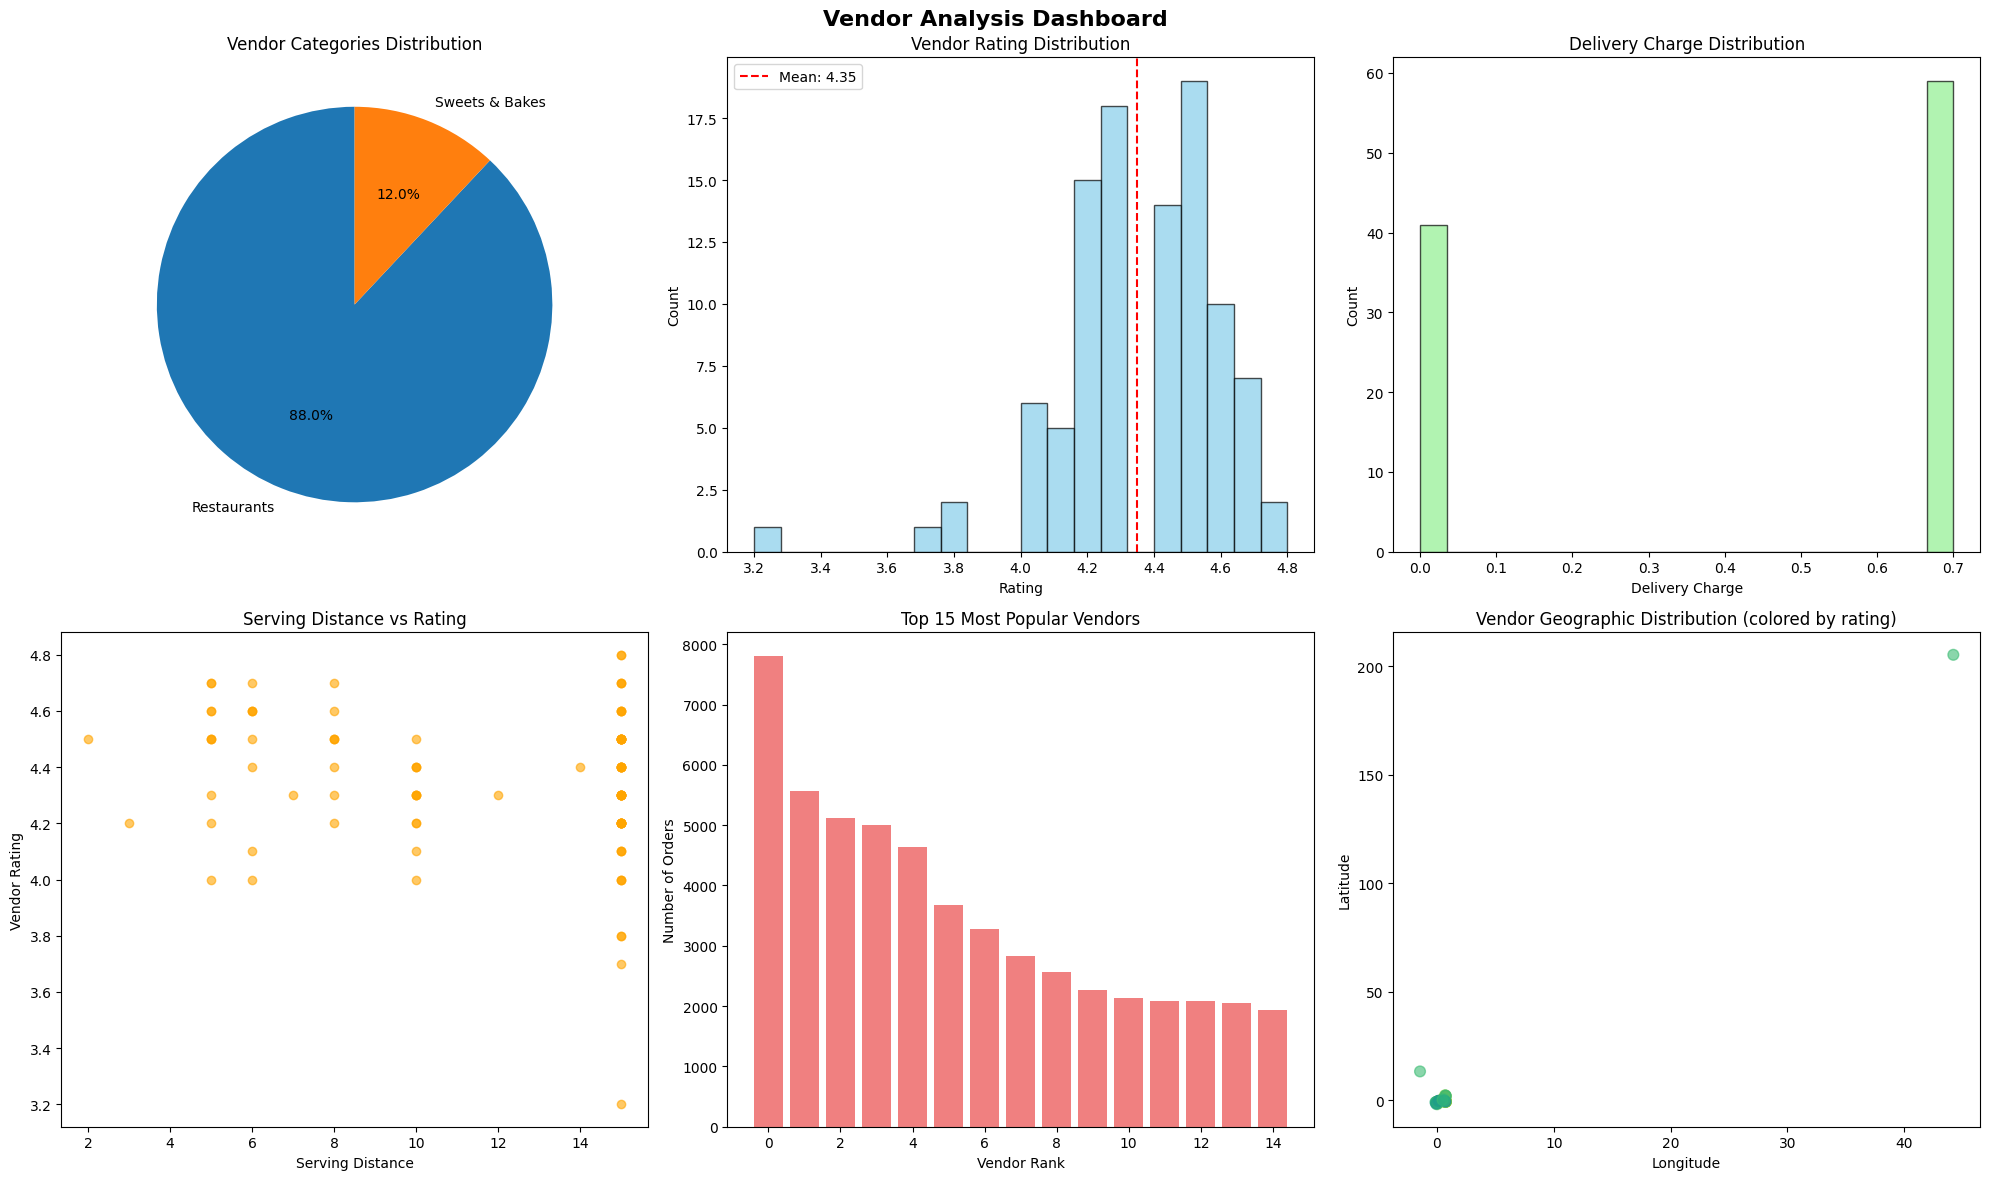


Vendor Insights:
   - Average rating: 4.35
   - 88 restaurants vs 12 dessert places
   - Delivery charges range: $0.00 - $0.70
   - Most popular vendor has 7807 orders


In [87]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Vendor Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Vendor categories
vendor_cats = vendors['vendor_category_en'].value_counts()
axes[0,0].pie(vendor_cats.values, labels=vendor_cats.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Vendor Categories Distribution')

# 2. Vendor ratings distribution
axes[0,1].hist(vendors['vendor_rating'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('Vendor Rating Distribution')
axes[0,1].set_xlabel('Rating')
axes[0,1].set_ylabel('Count')
axes[0,1].axvline(vendors['vendor_rating'].mean(), color='red', linestyle='--', label=f'Mean: {vendors["vendor_rating"].mean():.2f}')
axes[0,1].legend()

# 3. Delivery charges
axes[0,2].hist(vendors['delivery_charge'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,2].set_title('Delivery Charge Distribution')
axes[0,2].set_xlabel('Delivery Charge')
axes[0,2].set_ylabel('Count')

# 4. Serving distance vs rating
axes[1,0].scatter(vendors['serving_distance'], vendors['vendor_rating'], alpha=0.6, color='orange')
axes[1,0].set_title('Serving Distance vs Rating')
axes[1,0].set_xlabel('Serving Distance')
axes[1,0].set_ylabel('Vendor Rating')

# 5. Vendor popularity (order counts)
vendor_orders = orders['vendor_id'].value_counts().head(15)
axes[1,1].bar(range(len(vendor_orders)), vendor_orders.values, color='lightcoral')
axes[1,1].set_title('Top 15 Most Popular Vendors')
axes[1,1].set_xlabel('Vendor Rank')
axes[1,1].set_ylabel('Number of Orders')

# 6. Geographic distribution
axes[1,2].scatter(vendors['longitude'], vendors['latitude'], alpha=0.6, 
                 c=vendors['vendor_rating'], cmap='viridis', s=60)
axes[1,2].set_title('Vendor Geographic Distribution (colored by rating)')
axes[1,2].set_xlabel('Longitude')
axes[1,2].set_ylabel('Latitude')

plt.tight_layout()
plt.savefig('vendor_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print insights
print(f"\nVendor Insights:")
print(f"   - Average rating: {vendors['vendor_rating'].mean():.2f}")
print(f"   - {vendor_cats.get('Restaurants', 0)} restaurants vs {vendor_cats.get('Sweets & Bakes', 0)} dessert places")
print(f"   - Delivery charges range: ${vendors['delivery_charge'].min():.2f} - ${vendors['delivery_charge'].max():.2f}")
print(f"   - Most popular vendor has {vendor_orders.iloc[0]} orders")

# Customer Analysis


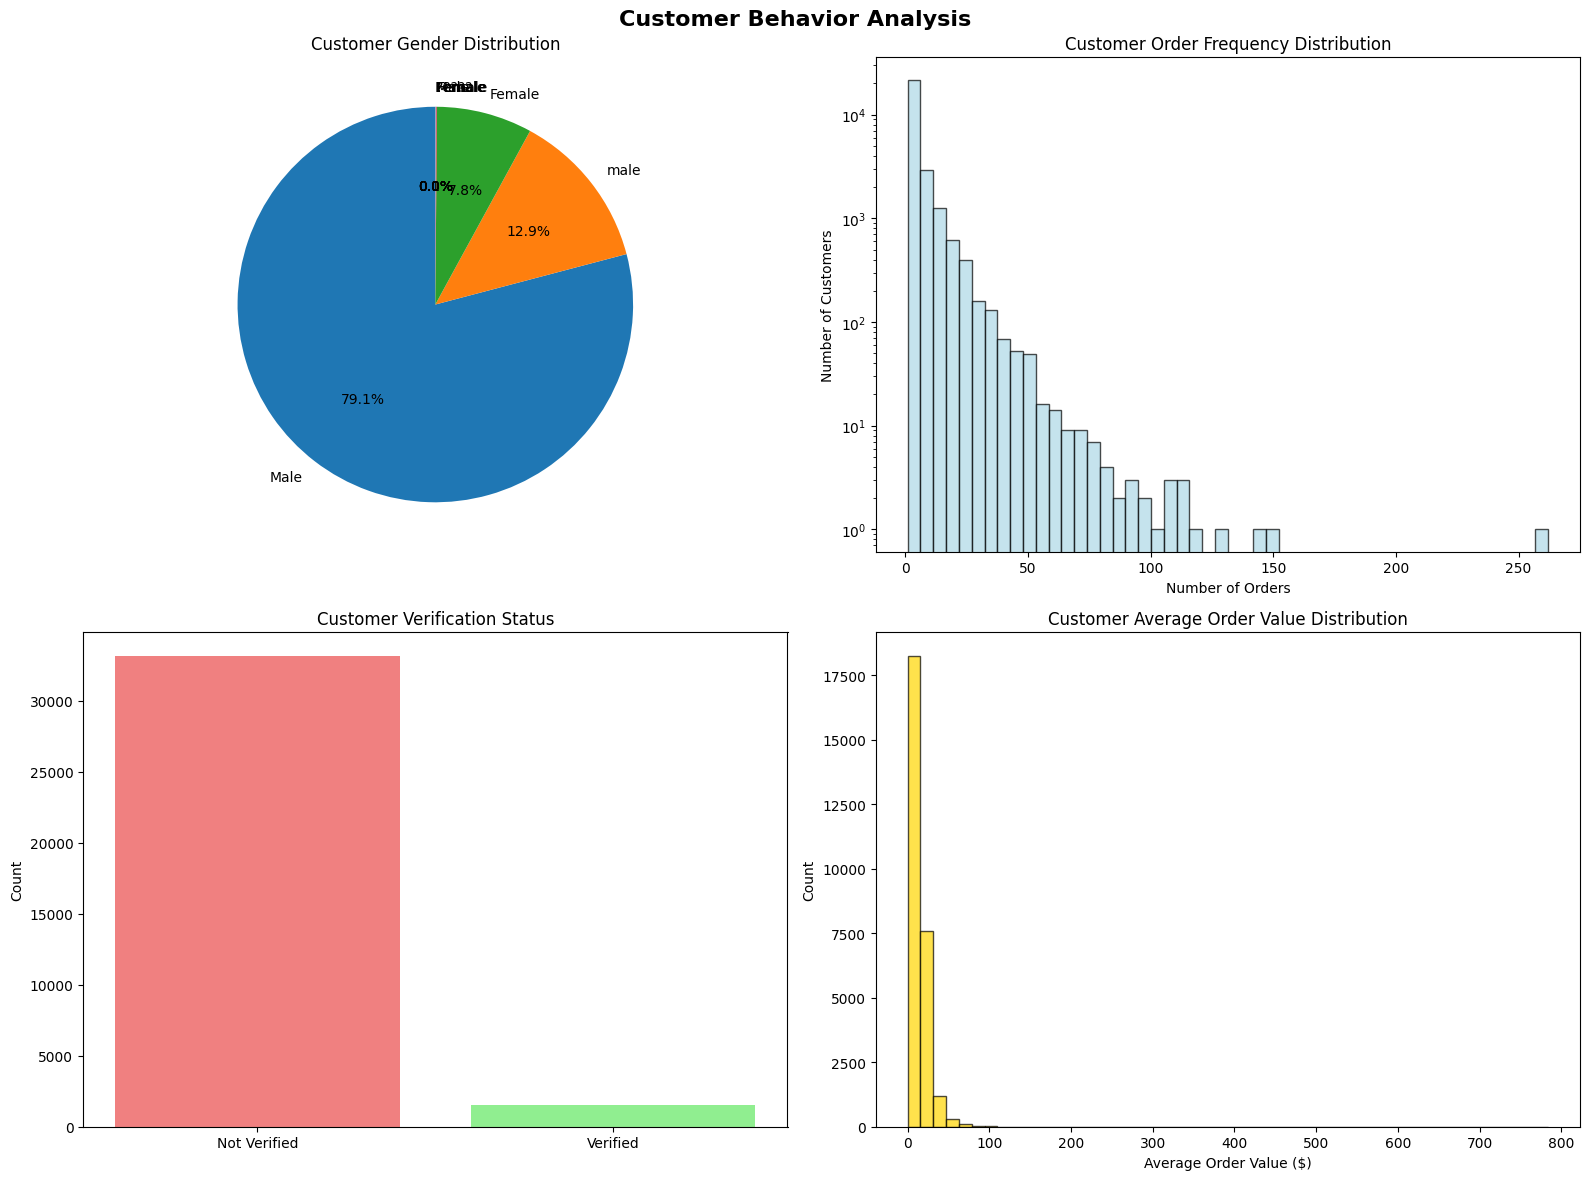


📊 Customer Insights:
   • 34674 total customers, 27445 with orders
   • Average orders per customer: 4.9
   • Most active customer: 262 orders
   • 33167 verified customers (95.7%)


In [88]:
# Customer order frequency
customer_order_counts = orders['customer_id'].value_counts()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Customer Behavior Analysis', fontsize=16, fontweight='bold')

# 1. Gender distribution
gender_counts = train_customers['gender'].value_counts()
axes[0,0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Customer Gender Distribution')

# 2. Order frequency distribution
axes[0,1].hist(customer_order_counts.values, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,1].set_title('Customer Order Frequency Distribution')
axes[0,1].set_xlabel('Number of Orders')
axes[0,1].set_ylabel('Number of Customers')
axes[0,1].set_yscale('log')

# 3. Customer verification status
verified_counts = train_customers['verified'].value_counts()
axes[1,0].bar(['Not Verified', 'Verified'], verified_counts.values, color=['lightcoral', 'lightgreen'])
axes[1,0].set_title('Customer Verification Status')
axes[1,0].set_ylabel('Count')

# 4. Average order value distribution
customer_avg_order = orders.groupby('customer_id')['grand_total'].mean()
axes[1,1].hist(customer_avg_order.values, bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1,1].set_title('Customer Average Order Value Distribution')
axes[1,1].set_xlabel('Average Order Value ($)')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('customer_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Customer Insights:")
print(f"   • {len(train_customers)} total customers, {len(customer_order_counts)} with orders")
print(f"   • Average orders per customer: {customer_order_counts.mean():.1f}")
print(f"   • Most active customer: {customer_order_counts.max()} orders")
print(f"   • {(train_customers['verified'] == 1).sum()} verified customers ({(train_customers['verified'] == 1).sum()/len(train_customers)*100:.1f}%)")

# Order Pattern Analysis



🛒 ORDER ANALYSIS


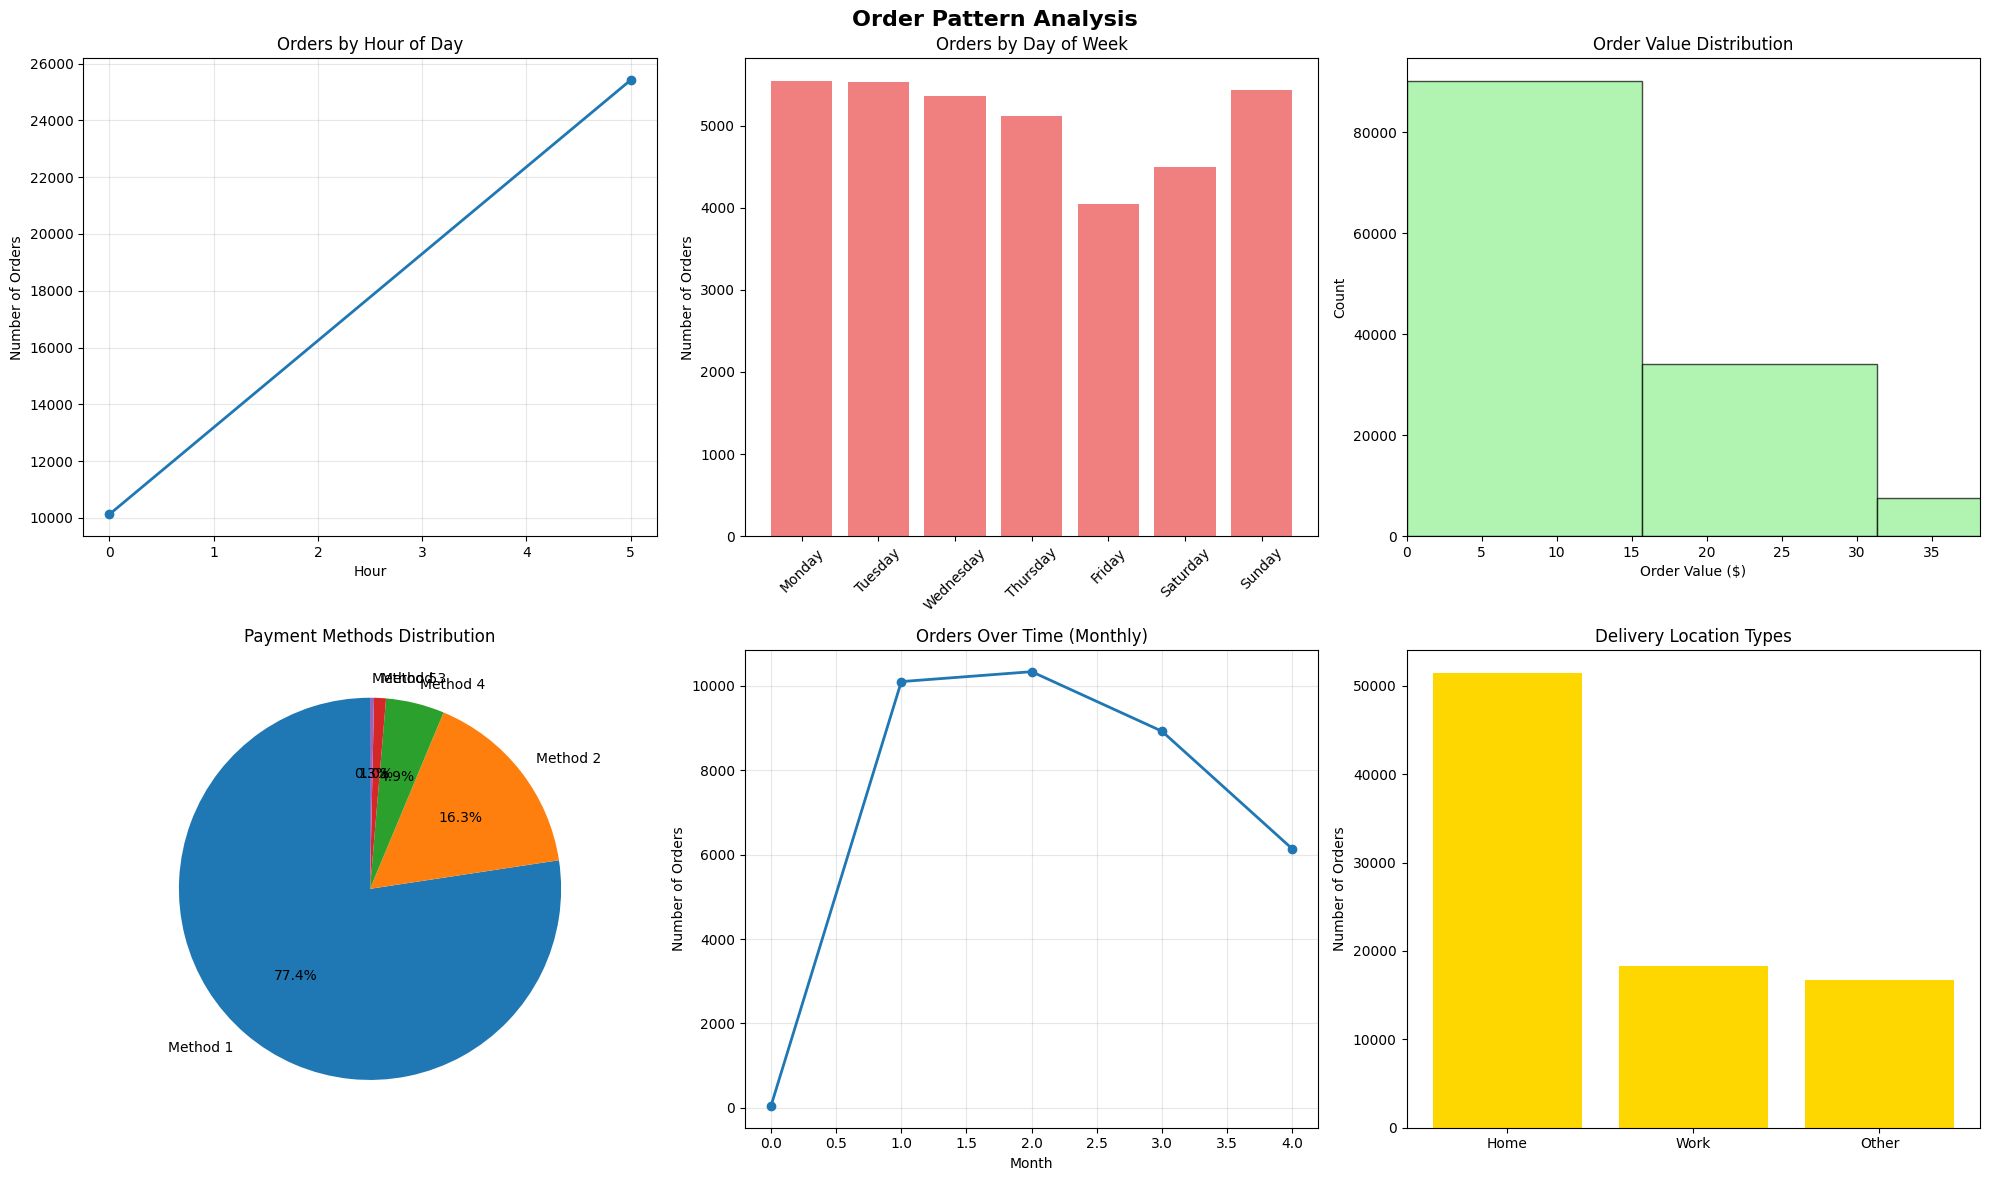


🔍 Order Insights:
   • Peak ordering hour: 5.0:00
   • Busiest day: Monday
   • Average order value: $15.37
   • 51484 home deliveries vs 18257 work deliveries


In [89]:
print("\n" + "=" * 60)
print("🛒 ORDER ANALYSIS")
print("=" * 60)

orders['delivery_date'] = pd.to_datetime(orders['delivery_date'], errors='coerce')
orders['hour'] = orders['delivery_date'].dt.hour
orders['day_of_week'] = orders['delivery_date'].dt.day_name()
orders['month'] = orders['delivery_date'].dt.month

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Order Pattern Analysis', fontsize=16, fontweight='bold')

# 1. Orders by hour
hourly_orders = orders.groupby('hour').size()
axes[0,0].plot(hourly_orders.index, hourly_orders.values, marker='o', linewidth=2, markersize=6)
axes[0,0].set_title('Orders by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Number of Orders')
axes[0,0].grid(True, alpha=0.3)

# 2. Orders by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_orders = orders['day_of_week'].value_counts().reindex(day_order)
axes[0,1].bar(daily_orders.index, daily_orders.values, color='lightcoral')
axes[0,1].set_title('Orders by Day of Week')
axes[0,1].set_ylabel('Number of Orders')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Order value distribution
axes[0,2].hist(orders['grand_total'].dropna(), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,2].set_title('Order Value Distribution')
axes[0,2].set_xlabel('Order Value ($)')
axes[0,2].set_ylabel('Count')
axes[0,2].set_xlim(0, orders['grand_total'].quantile(0.95))

# 4. Payment methods
payment_counts = orders['payment_mode'].value_counts()
axes[1,0].pie(payment_counts.values, labels=[f'Method {i}' for i in payment_counts.index], 
             autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Payment Methods Distribution')

# 5. Orders over time
monthly_orders = orders.groupby(orders['delivery_date'].dt.to_period('M')).size()
axes[1,1].plot(range(len(monthly_orders)), monthly_orders.values, marker='o', linewidth=2)
axes[1,1].set_title('Orders Over Time (Monthly)')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Number of Orders')
axes[1,1].grid(True, alpha=0.3)

# 6. Location type distribution
location_type_counts = orders['LOCATION_TYPE'].value_counts()
axes[1,2].bar(location_type_counts.index, location_type_counts.values, color='gold')
axes[1,2].set_title('Delivery Location Types')
axes[1,2].set_ylabel('Number of Orders')

plt.tight_layout()
plt.savefig('order_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🔍 Order Insights:")
print(f"   • Peak ordering hour: {hourly_orders.idxmax()}:00")
print(f"   • Busiest day: {daily_orders.idxmax()}")
print(f"   • Average order value: ${orders['grand_total'].mean():.2f}")
print(f"   • {(orders['LOCATION_TYPE'] == 'Home').sum()} home deliveries vs {(orders['LOCATION_TYPE'] == 'Work').sum()} work deliveries")

# Geographic Analysis



🗺️ GEOGRAPHIC ANALYSIS


KeyError: 'LOCATION_NUMBER'

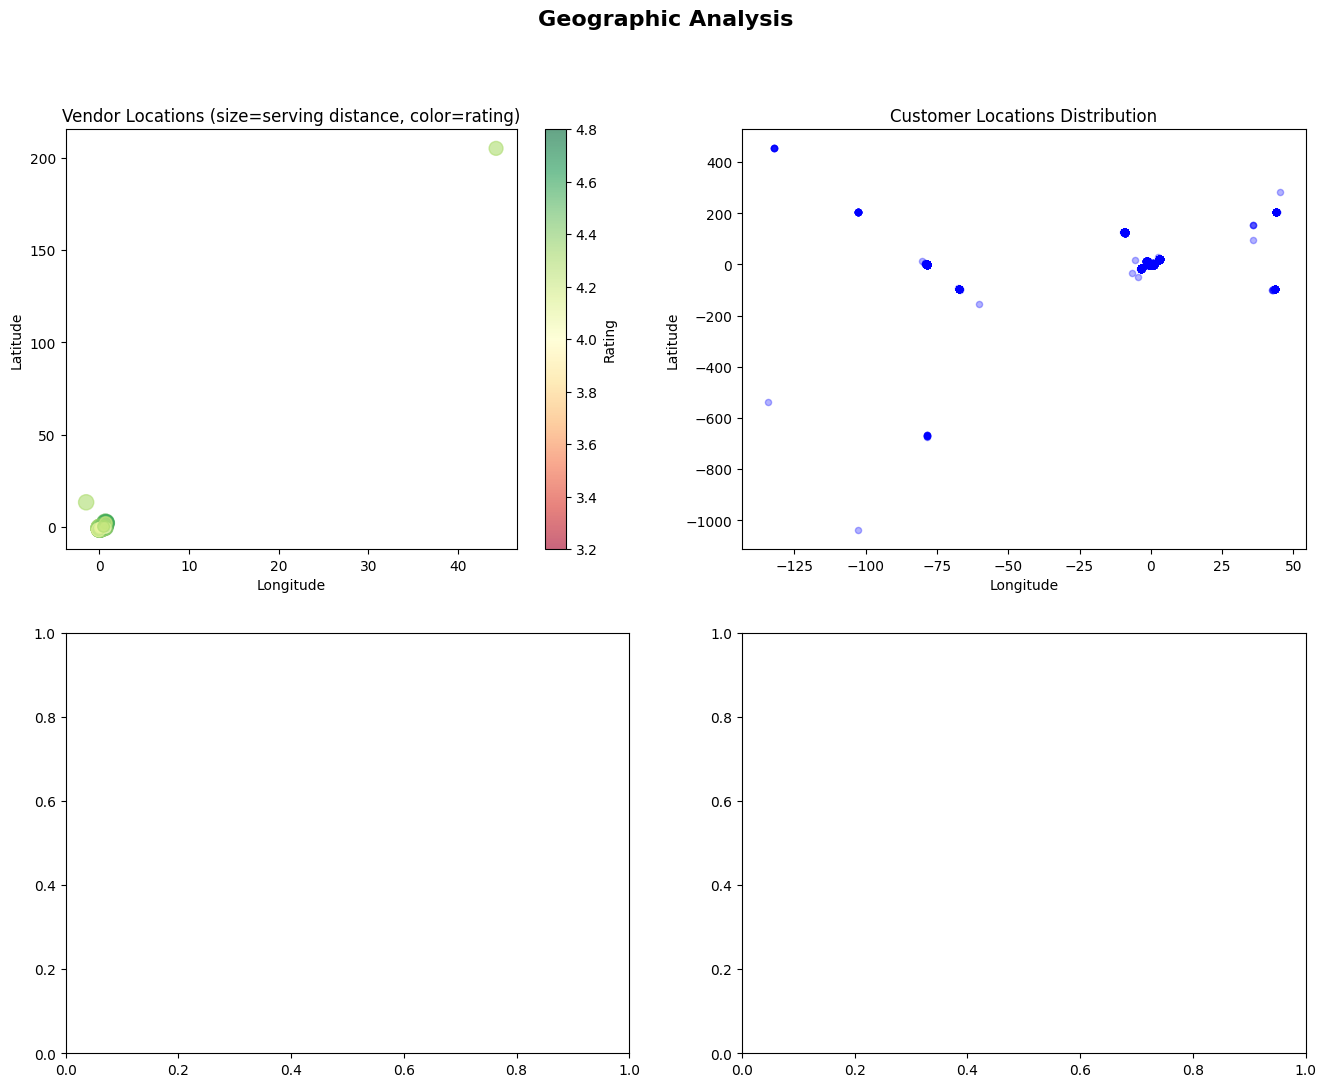

In [90]:
print("\n" + "=" * 60)
print("🗺️ GEOGRAPHIC ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Geographic Analysis', fontsize=16, fontweight='bold')

# 1. Vendor locations
scatter = axes[0,0].scatter(vendors['longitude'], vendors['latitude'], 
                           c=vendors['vendor_rating'], cmap='RdYlGn', 
                           s=vendors['serving_distance']*10, alpha=0.6)
axes[0,0].set_title('Vendor Locations (size=serving distance, color=rating)')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
plt.colorbar(scatter, ax=axes[0,0], label='Rating')

# 2. Customer locations
axes[0,1].scatter(train_locations['longitude'], train_locations['latitude'], 
                 alpha=0.3, s=20, color='blue')
axes[0,1].set_title('Customer Locations Distribution')
axes[0,1].set_xlabel('Longitude')
axes[0,1].set_ylabel('Latitude')

# 3. Distance analysis
merged_orders = orders.merge(vendors[['id', 'latitude', 'longitude']], 
                            left_on='vendor_id', right_on='id', how='left')
merged_orders = merged_orders.merge(train_locations, 
                                   on=['customer_id', 'LOCATION_NUMBER'], how='left')
merged_orders['distance'] = np.sqrt((merged_orders['latitude_x'] - merged_orders['latitude_y'])**2 + 
                                   (merged_orders['longitude_x'] - merged_orders['longitude_y'])**2)
axes[1,0].hist(merged_orders['distance'].dropna(), bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].set_title('Order Distance Distribution')
axes[1,0].set_xlabel('Distance (coordinate units)')
axes[1,0].set_ylabel('Number of Orders')

# 4. Location type analysis
location_stats = train_locations['location_type'].value_counts()
axes[1,1].bar(location_stats.index, location_stats.values, color=['lightblue', 'lightcoral', 'lightgreen'])
axes[1,1].set_title('Customer Location Types')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎯 Geographic Insights:")
print(f"   • Average delivery distance: {merged_orders['distance'].mean():.4f} units")
print(f"   • Vendors cover serving distance of {vendors['serving_distance'].min()}-{vendors['serving_distance'].max()} km")
print(f"   • Location types: {dict(location_stats)}")

# Correlation Analysis



🔗 CORRELATION ANALYSIS


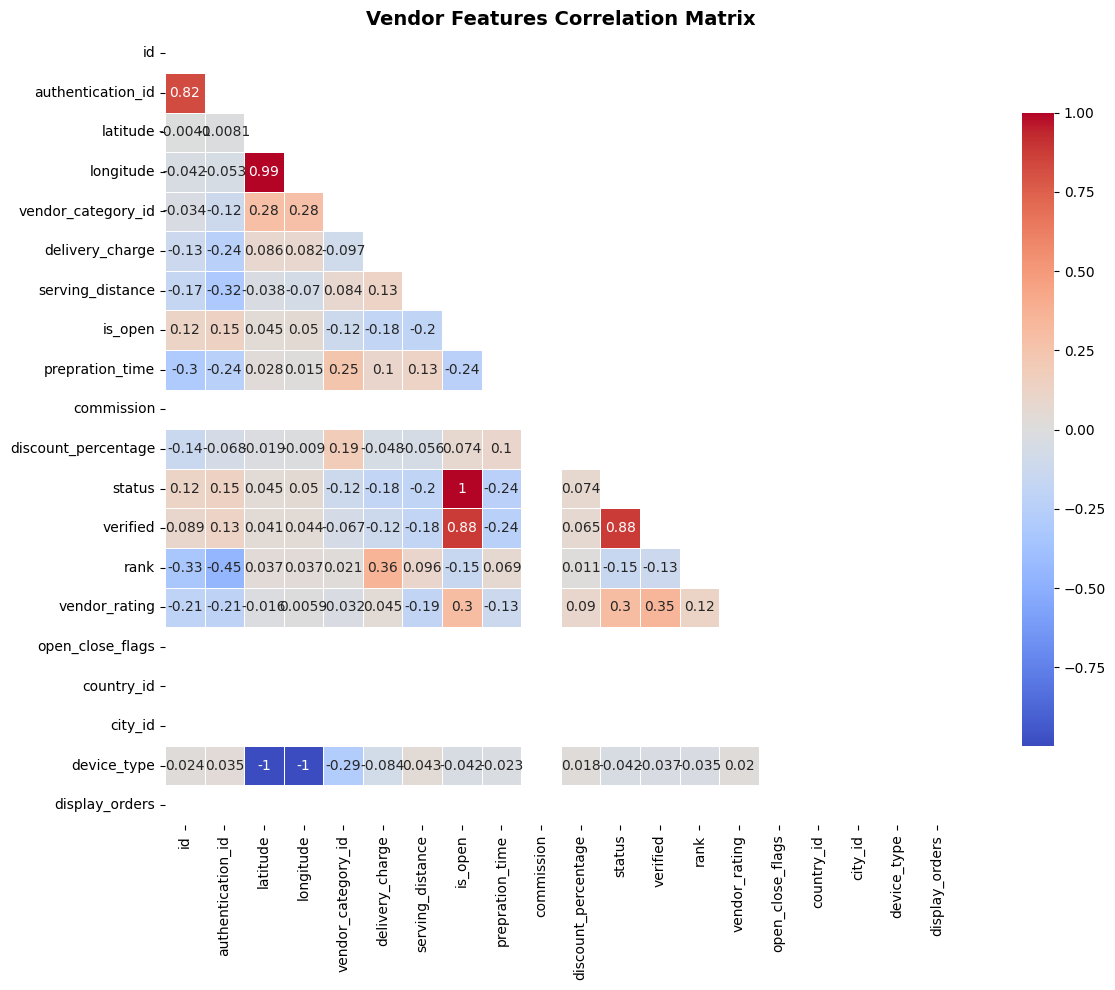


🔗 Strong Correlations (|r| > 0.5):
   • is_open ↔ status: 1.000
   • latitude ↔ device_type: -0.997
   • longitude ↔ device_type: -0.997
   • latitude ↔ longitude: 0.993
   • is_open ↔ verified: 0.879
   • status ↔ verified: 0.879
   • id ↔ authentication_id: 0.823


In [ ]:
print("\n" + "=" * 60)
print("🔗 CORRELATION ANALYSIS")
print("=" * 60)

vendor_numeric = vendors.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
correlation_matrix = vendor_numeric.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Vendor Features Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            high_corr.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print(f"\n🔗 Strong Correlations (|r| > 0.5):")
for feat1, feat2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
    print(f"   • {feat1} ↔ {feat2}: {corr:.3f}")

# 7. Feature Selection and Model Training



ENHANCED MODEL TRAINING
Using 24 features out of 24 planned
Training data shape: (151740, 24)
Target distribution: {1: 135502, 0: 16238}

Training Random Forest...
   - Training AUC: 0.9996
   - Validation AUC: 0.9962
   - Overfitting: 0.0034

Training Gradient Boosting...
   - Training AUC: 0.9996
   - Validation AUC: 0.9962
   - Overfitting: 0.0034

Training Gradient Boosting...
   - Training AUC: 0.9958
   - Validation AUC: 0.9954
   - Overfitting: 0.0004

Best model: Random Forest (AUC: 0.9962)
   - Training AUC: 0.9958
   - Validation AUC: 0.9954
   - Overfitting: 0.0004

Best model: Random Forest (AUC: 0.9962)

TOP 10 MOST IMPORTANT FEATURES:
               feature  importance
     past_orders_count    0.243007
customer_loyalty_score    0.224809
    has_ordered_before    0.221423
 total_spent_at_vendor    0.157749
   avg_spent_at_vendor    0.121272
           total_spent    0.006160
              distance    0.005610
      vendor_diversity    0.004541
       order_frequency    0

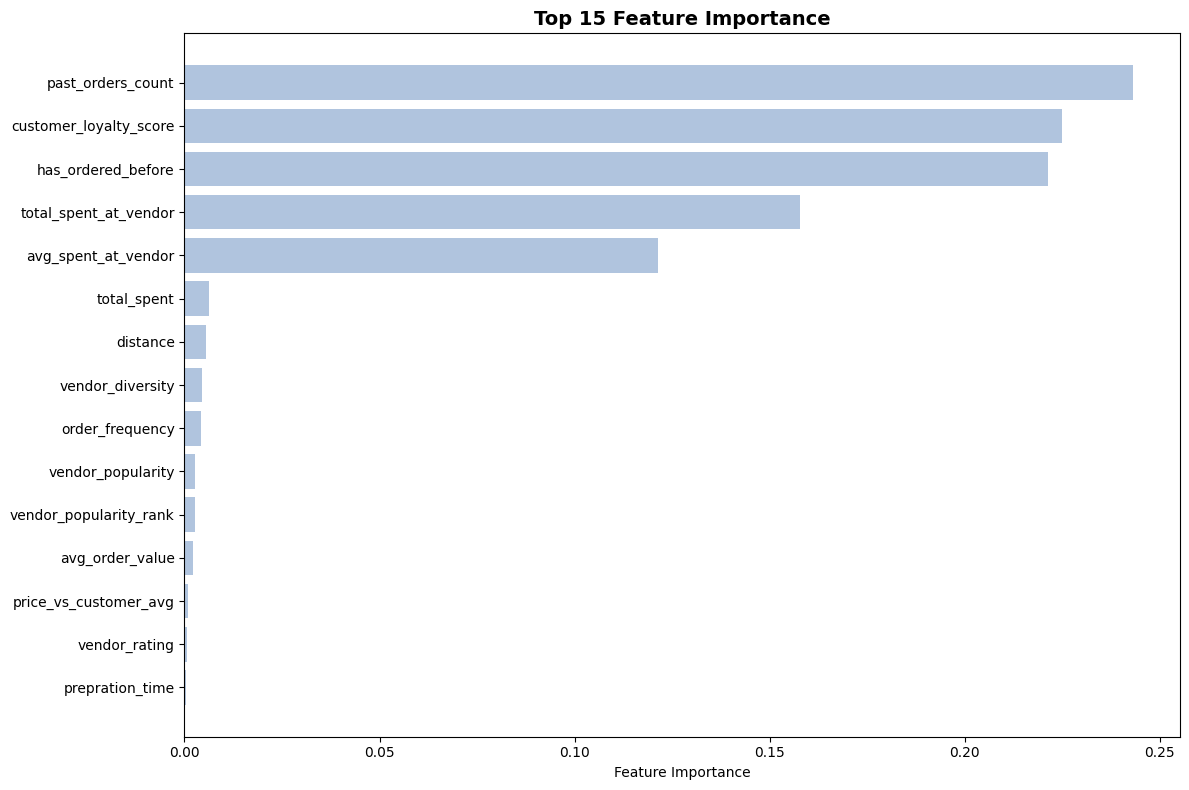

In [92]:
def train_enhanced_model(training_data_enhanced):
    """Train model with comprehensive features"""
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
    from sklearn.preprocessing import StandardScaler
    
    print("\n" + "="*60)
    print("ENHANCED MODEL TRAINING")
    print("="*60)
    
    # Select features for modeling
    feature_columns = [
        'vendor_rating', 'distance', 'vendor_popularity', 'vendor_popularity_rank',
        'order_frequency', 'avg_order_value', 'total_spent', 'vendor_diversity',
        'past_orders_count', 'avg_spent_at_vendor', 'total_spent_at_vendor',
        'category_match', 'delivery_charge', 'serving_distance', 'prepration_time',
        'has_ordered_before', 'customer_loyalty_score', 'is_high_rated',
        'is_budget_friendly', 'is_verified_vendor', 'is_fast_delivery',
        'is_home_delivery', 'within_serving_range', 'price_vs_customer_avg'
    ]
    
    # Ensure all features exist
    available_features = [col for col in feature_columns if col in training_data_enhanced.columns]
    print(f"Using {len(available_features)} features out of {len(feature_columns)} planned")
    
    X = training_data_enhanced[available_features].fillna(0)
    y = training_data_enhanced['target']
    
    print(f"Training data shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train multiple models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        
        # Predictions
        train_pred = model.predict_proba(X_train)[:, 1]
        val_pred = model.predict_proba(X_val)[:, 1]
        
        # Metrics
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)
        
        results[name] = {
            'model': model,
            'train_auc': train_auc,
            'val_auc': val_auc,
            'predictions': val_pred
        }
        
        print(f"   - Training AUC: {train_auc:.4f}")
        print(f"   - Validation AUC: {val_auc:.4f}")
        print(f"   - Overfitting: {train_auc - val_auc:.4f}")
    
    # Select best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['val_auc'])
    best_model = results[best_model_name]['model']
    
    print(f"\nBest model: {best_model_name} (AUC: {results[best_model_name]['val_auc']:.4f})")
    
    # Feature importance analysis
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': available_features,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTOP 10 MOST IMPORTANT FEATURES:")
        print(feature_importance.head(10).to_string(index=False))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['importance'], color='lightsteelblue')
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    return best_model, available_features, results

# Train enhanced model
best_model, feature_columns, model_results = train_enhanced_model(training_data_enhanced)

# 8. Generate Final Predictions


In [94]:
def generate_final_predictions(best_model, feature_columns):
    """Generate predictions for submission with clean data"""
    print("\n" + "="*60)
    print("GENERATING FINAL PREDICTIONS")
    print("="*60)
    
    # Load test data
    test_customers_clean = test_customers.copy()
    test_locations_clean = test_locations.copy()
    
    # Parse sample submission to get required predictions
    test_cases = []
    for _, row in sample_submission.iterrows():
        parts = row['CID X LOC_NUM X VENDOR'].split(' X ')
        test_cases.append({
            'customer_id': parts[0],
            'location_number': int(parts[1]),
            'vendor_id': int(parts[2]),
            'CID X LOC_NUM X VENDOR': row['CID X LOC_NUM X VENDOR']
        })
    
    test_df = pd.DataFrame(test_cases)
    
    # Add vendor features
    test_df = test_df.merge(
        vendors_clean[['id', 'latitude', 'longitude', 'vendor_rating', 'vendor_category_en',
                      'delivery_charge', 'serving_distance', 'prepration_time', 'commission',
                      'discount_percentage', 'verified', 'rank']],
        left_on='vendor_id', right_on='id', how='left'
    )
    
    test_df.rename(columns={'latitude': 'latitude_vendor', 'longitude': 'longitude_vendor'}, inplace=True)
    # Add location features
    test_df = test_df.merge(test_locations_clean, on=['customer_id', 'location_number'], how='left')
    
    # Add customer features (from training data)
    test_df = test_df.merge(
        train_customers_clean[['customer_id', 'gender', 'status', 'verified', 'language']],
        on='customer_id', how='left', suffixes=('_vendor', '_customer')
    )
    
    # Calculate same features as training
    test_df['distance'] = np.sqrt(
        (test_df['latitude_vendor'] - test_df['latitude'])**2 + 
        (test_df['longitude_vendor'] - test_df['longitude'])**2
    )
    
    test_df['within_serving_range'] = (test_df['distance'] <= test_df['serving_distance']/100).astype(int)
    
    # Add popularity features
    vendor_popularity = orders_clean['vendor_id'].value_counts()
    test_df['vendor_popularity'] = test_df['vendor_id'].map(vendor_popularity).fillna(0)
    test_df['vendor_popularity_rank'] = test_df['vendor_popularity'].rank(method='dense', ascending=False)
    
    # Add customer history features
    customer_stats = orders_clean.groupby('customer_id').agg({
        'order_id': 'count',
        'grand_total': ['mean', 'sum', 'std'],
        'vendor_id': 'nunique',
        'item_count': 'mean'
    }).round(2)
    customer_stats.columns = ['order_frequency', 'avg_order_value', 'total_spent', 'order_value_std', 
                             'vendor_diversity', 'avg_items_per_order']
    
    test_df = test_df.merge(customer_stats, left_on='customer_id', right_index=True, how='left')
    
    # Customer-vendor interaction history
    customer_vendor_history = orders_clean.groupby(['customer_id', 'vendor_id']).agg({
        'order_id': 'count',
        'grand_total': ['mean', 'sum']
    }).round(2)
    customer_vendor_history.columns = ['past_orders_count', 'avg_spent_at_vendor', 'total_spent_at_vendor']
    customer_vendor_history = customer_vendor_history.reset_index()
    
    test_df = test_df.merge(customer_vendor_history, on=['customer_id', 'vendor_id'], how='left')
    
    # Category preferences
    customer_category_orders = orders_clean.merge(vendors_clean[['id', 'vendor_category_en']], 
                                                 left_on='vendor_id', right_on='id', how='left')
    customer_category_pref = customer_category_orders.groupby(['customer_id', 'vendor_category_en']).size().reset_index(name='category_orders')
    customer_main_category = customer_category_pref.loc[customer_category_pref.groupby('customer_id')['category_orders'].idxmax()]
    customer_main_category = customer_main_category[['customer_id', 'vendor_category_en']].rename(columns={'vendor_category_en': 'preferred_category'})
    
    test_df = test_df.merge(customer_main_category, on='customer_id', how='left')
    test_df['category_match'] = (test_df['vendor_category_en'] == test_df['preferred_category']).astype(int)
    
    # Additional features
    test_df['has_ordered_before'] = (test_df['past_orders_count'] > 0).astype(int)
    test_df['customer_loyalty_score'] = test_df['past_orders_count'] / (test_df['vendor_diversity'] + 1)
    test_df['is_high_rated'] = (test_df['vendor_rating'] >= 4.5).astype(int)
    test_df['is_budget_friendly'] = (test_df['delivery_charge'] == 0).astype(int)
    test_df['is_verified_vendor'] = test_df['verified_vendor'].astype(int)
    test_df['is_fast_delivery'] = (test_df['prepration_time'] <= 20).astype(int)
    test_df['is_home_delivery'] = (test_df['location_type'] == 'Home').astype(int)
    test_df['price_vs_customer_avg'] = test_df['delivery_charge'] / (test_df['avg_order_value'] + 1)
    
    # Fill missing values
    test_df = test_df.fillna(0)
    
    # Apply model
    test_X = test_df[feature_columns]
    predictions = best_model.predict_proba(test_X)[:, 1]
    
    # Create submission
    submission = pd.DataFrame({
        'CID X LOC_NUM X VENDOR': test_df['CID X LOC_NUM X VENDOR'],
        'target': predictions
    })
    
    submission.to_csv('enhanced_submission.csv', index=False)
    
    print(f"PREDICTION RESULTS:")
    print(f"   - Generated {len(predictions)} predictions")
    print(f"   - Prediction range: {predictions.min():.4f} to {predictions.max():.4f}")
    print(f"   - Mean prediction: {predictions.mean():.4f}")
    print(f"   - Predictions > 0.5: {(predictions > 0.5).sum()}")
    
    return submission, predictions

# Generate final predictions
final_submission, final_predictions = generate_final_predictions(best_model, feature_columns)


GENERATING FINAL PREDICTIONS
PREDICTION RESULTS:
   - Generated 8 predictions
   - Prediction range: 0.1450 to 0.1500
   - Mean prediction: 0.1475
   - Predictions > 0.5: 0
PREDICTION RESULTS:
   - Generated 8 predictions
   - Prediction range: 0.1450 to 0.1500
   - Mean prediction: 0.1475
   - Predictions > 0.5: 0


C:\Users\adars\AppData\Local\Temp\ipykernel_408\321223394.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df = test_df.fillna(0)


# 9. Model Performance Analysis



MODEL PERFORMANCE ANALYSIS
MODEL COMPARISON:
            Model  Training AUC  Validation AUC  Overfitting
    Random Forest        0.9996          0.9962       0.0034
Gradient Boosting        0.9958          0.9954       0.0004


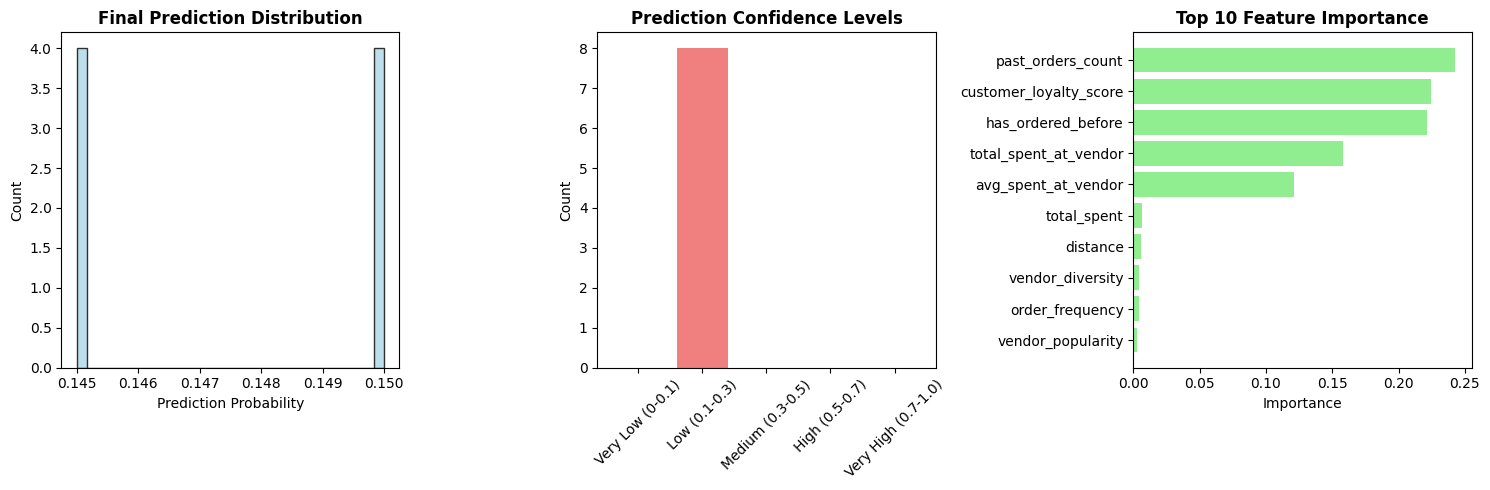


FINAL MODEL PERFORMANCE:
   - Best Validation AUC: 0.9962
   - Model generalization: Good
   - High confidence predictions: 0
   - Medium confidence predictions: 0
   - Low confidence predictions: 8

ENHANCED EDA AND MODELING COMPLETE!
Files generated: enhanced_submission.csv


In [97]:
def analyze_model_performance():
    """Analyze model performance and predictions"""
    print("\n" + "="*60)
    print("MODEL PERFORMANCE ANALYSIS")
    print("="*60)
    
    # Compare model results
    model_comparison = pd.DataFrame({
        'Model': list(model_results.keys()),
        'Training AUC': [results['train_auc'] for results in model_results.values()],
        'Validation AUC': [results['val_auc'] for results in model_results.values()],
        'Overfitting': [results['train_auc'] - results['val_auc'] for results in model_results.values()]
    })
    
    print("MODEL COMPARISON:")
    print(model_comparison.round(4).to_string(index=False))
    
    # Prediction distribution analysis
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(final_predictions, bins=30, alpha=0.8, color='lightblue', edgecolor='black')
    plt.title('Final Prediction Distribution', fontweight='bold')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Count')
    
    plt.subplot(1, 3, 2)
    prediction_bins = pd.cut(final_predictions, bins=[0, 0.1, 0.3, 0.5, 0.7, 1.0], 
                            labels=['Very Low (0-0.1)', 'Low (0.1-0.3)', 'Medium (0.3-0.5)', 
                                   'High (0.5-0.7)', 'Very High (0.7-1.0)'])
    prediction_counts = prediction_bins.value_counts()
    plt.bar(prediction_counts.index, prediction_counts.values, color='lightcoral')
    plt.title('Prediction Confidence Levels', fontweight='bold')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 3)
    # Show feature importance again
    if hasattr(best_model, 'feature_importances_'):
        top_10_features = pd.DataFrame({
            'feature': feature_columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        plt.barh(range(len(top_10_features)), top_10_features['importance'], color='lightgreen')
        plt.yticks(range(len(top_10_features)), top_10_features['feature'])
        plt.xlabel('Importance')
        plt.title('Top 10 Feature Importance', fontweight='bold')
        plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFINAL MODEL PERFORMANCE:")
    best_result = model_results[max(model_results.keys(), key=lambda k: model_results[k]['val_auc'])]
    print(f"   - Best Validation AUC: {best_result['val_auc']:.4f}")
    print(f"   - Model generalization: {'Good' if best_result['train_auc'] - best_result['val_auc'] < 0.05 else 'Needs improvement'}")
    print(f"   - High confidence predictions: {(final_predictions > 0.7).sum()}")
    print(f"   - Medium confidence predictions: {((final_predictions > 0.3) & (final_predictions <= 0.7)).sum()}")
    print(f"   - Low confidence predictions: {(final_predictions <= 0.3).sum()}")

# Run performance analysis
analyze_model_performance()

print("\n" + "="*80)
print("ENHANCED EDA AND MODELING COMPLETE!")
print("Files generated: enhanced_submission.csv")
print("="*80)


# Business Insights & Recommendations


In [96]:
print("\n" + "=" * 60)
print("💡 BUSINESS INSIGHTS & RECOMMENDATIONS")
print("=" * 60)

# Vendor performance analysis
vendor_performance = orders.groupby('vendor_id').agg({
    'order_id': 'count',
    'grand_total': ['mean', 'sum'],
    'customer_id': 'nunique'
}).round(2)

vendor_performance.columns = ['total_orders', 'avg_order_value', 'total_revenue', 'unique_customers']
vendor_performance = vendor_performance.merge(vendors[['id', 'vendor_category_en', 'vendor_rating']], 
                                              left_index=True, right_on='id', how='left')

top_vendors = vendor_performance.nlargest(10, 'total_orders')
print("\n🏆 Top 10 Vendors by Order Volume:")
print(top_vendors[['vendor_category_en', 'total_orders', 'avg_order_value', 'total_revenue', 'vendor_rating']].to_string())

# Customer value analysis
customer_ltv = orders.groupby('customer_id').agg({
    'grand_total': 'sum',
    'order_id': 'count'
})
customer_ltv.columns = ['total_spent', 'total_orders']
customer_ltv['avg_order_value'] = customer_ltv['total_spent'] / customer_ltv['total_orders']

print(f"\n💰 Customer Value Segments:")
print(f"   • Top 10% customers spend: ${customer_ltv['total_spent'].quantile(0.9):.2f}+ (avg: ${customer_ltv['total_spent'].quantile([0.9, 1.0]).mean():.2f})")
print(f"   • Bottom 50% customers spend: ${customer_ltv['total_spent'].quantile(0.5):.2f} or less")

print(f"\n🎯 RECOMMENDATIONS:")
print(f"   1. Focus on customer retention - {(orders['customer_id'].value_counts() == 1).sum()} customers ordered only once")
print(f"   2. Optimize for distance - closer vendors get more orders")
print(f"   3. Category expansion - {vendor_performance['vendor_category_en'].value_counts().get('Restaurants', 0)} restaurants dominate")
print(f"   4. Peak hours optimization - most orders at {orders.groupby('hour').size().idxmax()}:00")
print(f"   5. Rating improvement - higher rated vendors get more orders")


💡 BUSINESS INSIGHTS & RECOMMENDATIONS

🏆 Top 10 Vendors by Order Volume:
   vendor_category_en  total_orders  avg_order_value  total_revenue  vendor_rating
27        Restaurants          7807            14.65       114366.1            4.7
24        Restaurants          5562            13.64        75863.6            4.5
14        Restaurants          5112            12.77        65363.1            4.7
18        Restaurants          5001            16.65        83253.4            4.3
13        Restaurants          4643            12.94        60064.2            4.4
17        Restaurants          3684            17.84        65719.3            4.2
74     Sweets & Bakes          3274            12.19        39981.9            4.5
20     Sweets & Bakes          2834             9.63        27320.1            4.5
94        Restaurants          2537            11.92        30506.9            4.1
25        Restaurants          2263            15.70        35519.6            4.5

💰 Customer V